# Movie Rating Prediction - Machine Learning Project

This project trains a machine learning model to predict movie ratings and evaluates it using MAE, MSE, RMSE, and R² metrics.


In [74]:
# Install required packages (run this cell if needed)
# !pip install pandas numpy scikit-learn matplotlib seaborn scipy xgboost


In [75]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy.stats import randint, uniform
from scipy import sparse
import warnings
import json
import ast
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load and Explore the Data


In [76]:
# Load the ratings dataset with memory optimization
print("Loading ratings dataset (memory-optimized)...")

# Option 1: Read in chunks and sample if needed
USE_FULL_DATA = False  # Set to True to use all 26M rows (requires 8GB+ RAM)
CHUNK_SIZE = 500000  # Read 500K rows at a time
MAX_ROWS = 3000000 if not USE_FULL_DATA else None  # Limit to 3M rows if sampling

if USE_FULL_DATA:
    # Read full dataset with optimized dtypes
    print("   - Reading full dataset with optimized data types...")
    ratings_df = pd.read_csv(
        'data set/ratings.csv',
        dtype={
            'userId': 'int32',
            'movieId': 'int32',
            'rating': 'float32',
            'timestamp': 'int64'
        },
        low_memory=False
    )
else:
    # Read in chunks and sample for memory efficiency
    print(f"   - Reading dataset in chunks and sampling up to {MAX_ROWS:,} rows...")
    chunks = []
    total_rows = 0
    
    for chunk in pd.read_csv(
        'data set/ratings.csv',
        chunksize=CHUNK_SIZE,
        dtype={
            'userId': 'int32',
            'movieId': 'int32',
            'rating': 'float32',
            'timestamp': 'int64'
        },
        low_memory=False
    ):
        if MAX_ROWS and total_rows >= MAX_ROWS:
            break
        
        remaining = MAX_ROWS - total_rows if MAX_ROWS else len(chunk)
        if MAX_ROWS and len(chunk) > remaining:
            chunk = chunk.head(remaining)
        
        chunks.append(chunk)
        total_rows += len(chunk)
        
        if total_rows % 1000000 == 0:
            print(f"     - Loaded {total_rows:,} rows...")
        
        if MAX_ROWS and total_rows >= MAX_ROWS:
            break
    
    ratings_df = pd.concat(chunks, ignore_index=True)
    del chunks  # Free memory
    import gc
    gc.collect()

print(f"\n✅ Dataset loaded successfully!")
print(f"Ratings Data Shape: {ratings_df.shape}")
print(f"Memory usage: {ratings_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
print(ratings_df.head())
print("\nData Info:")
print(ratings_df.info(memory_usage='deep'))
print("\nBasic Statistics:")
print(ratings_df.describe())


Loading ratings dataset (memory-optimized)...
   - Reading dataset in chunks and sampling up to 3,000,000 rows...
     - Loaded 1,000,000 rows...
     - Loaded 2,000,000 rows...
     - Loaded 3,000,000 rows...

✅ Dataset loaded successfully!
Ratings Data Shape: (3000000, 4)
Memory usage: 57.22 MB

First few rows:
   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     1221     5.0  1425941546
4       1     1246     5.0  1425941556

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float32
 3   timestamp  int64  
dtypes: float32(1), int32(2), int64(1)
memory usage: 57.2 MB
None

Basic Statistics:
             userId       movieId        rating     timestamp
count  3.000000e+06  3.000000e+06  3

In [77]:
# Load movies metadata for additional features
movies_df = pd.read_csv('data set/movies_metadata.csv', low_memory=False)
print("Movies Data Shape:", movies_df.shape)
print("\nMovies Columns:", movies_df.columns.tolist()[:10])


Movies Data Shape: (45466, 24)

Movies Columns: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview']


## 2. Data Preparation and Feature Engineering


In [78]:
# Calculate user and movie statistics for feature engineering
print("Calculating user statistics...")
user_stats = ratings_df.groupby('userId')['rating'].agg(['mean', 'count', 'std']).reset_index()
user_stats.columns = ['userId', 'user_avg_rating', 'user_rating_count', 'user_rating_std']
user_stats = user_stats.fillna(0)

print("Calculating movie statistics...")
movie_stats = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count', 'std']).reset_index()
movie_stats.columns = ['movieId', 'movie_avg_rating', 'movie_rating_count', 'movie_rating_std']
movie_stats = movie_stats.fillna(0)

# Ensure merge keys have same data type
user_stats['userId'] = user_stats['userId'].astype(ratings_df['userId'].dtype)
movie_stats['movieId'] = movie_stats['movieId'].astype(ratings_df['movieId'].dtype)

print("User Statistics Shape:", user_stats.shape)
print("Movie Statistics Shape:", movie_stats.shape)
print("\nData types check:")
print(f"ratings_df userId dtype: {ratings_df['userId'].dtype}")
print(f"user_stats userId dtype: {user_stats['userId'].dtype}")
print(f"ratings_df movieId dtype: {ratings_df['movieId'].dtype}")
print(f"movie_stats movieId dtype: {movie_stats['movieId'].dtype}")


Calculating user statistics...
Calculating movie statistics...
User Statistics Shape: (31332, 4)
Movie Statistics Shape: (26511, 4)

Data types check:
ratings_df userId dtype: int32
user_stats userId dtype: int32
ratings_df movieId dtype: int32
movie_stats movieId dtype: int32


In [79]:
# Merge statistics with ratings data
print("Step 1: Merging statistics with ratings data...")

# Memory optimization: Sample data if too large (uncomment to use)
USE_SAMPLE = False  # Set to True if you encounter memory errors
SAMPLE_SIZE = 2000000  # 2M samples (adjust based on available RAM)

if USE_SAMPLE and len(ratings_df) > SAMPLE_SIZE:
    print(f"   - Dataset too large ({len(ratings_df):,} rows). Sampling {SAMPLE_SIZE:,} rows for memory efficiency...")
    ratings_df = ratings_df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print(f"   - Sampled dataset shape: {ratings_df.shape}")

# Ensure data types match before merging
ratings_df['userId'] = ratings_df['userId'].astype(user_stats['userId'].dtype)
ratings_df['movieId'] = ratings_df['movieId'].astype(movie_stats['movieId'].dtype)

# Perform merges with error handling
try:
    print("   - Merging user statistics...")
    df = ratings_df.merge(user_stats, on='userId', how='left', suffixes=('', '_user'))
    print(f"   - User stats merged. Shape: {df.shape}")
    
    print("   - Merging movie statistics...")
    df = df.merge(movie_stats, on='movieId', how='left', suffixes=('', '_movie'))
    print(f"   - Movie stats merged. Shape: {df.shape}")
    
    # Check for duplicate columns and drop if any
    duplicate_cols = [col for col in df.columns if df.columns.tolist().count(col) > 1]
    if duplicate_cols:
        df = df.loc[:, ~df.columns.duplicated()]
        print(f"   - Removed duplicate columns: {duplicate_cols}")
    
    print("✅ Step 1: Basic statistics merged successfully!")
    
except Exception as e:
    print(f"❌ Error during merge: {e}")
    print(f"ratings_df columns: {ratings_df.columns.tolist()}")
    print(f"user_stats columns: {user_stats.columns.tolist()}")
    print(f"movie_stats columns: {movie_stats.columns.tolist()}")
    raise

# Advanced Feature Engineering for Higher Accuracy
print("\nStep 2: Creating advanced features...")

# ========== SVD Matrix Factorization Features (Collaborative Filtering) ==========
print("   - Creating SVD features for collaborative filtering...")
print("     (Using efficient sparse matrix approach for large dataset)")

try:
    # Sample data for SVD (use larger sample but still manageable)
    svd_sample_size = min(50000, len(df))
    svd_sample_idx = np.random.choice(len(df), svd_sample_size, replace=False)
    df_svd_sample = df.iloc[svd_sample_idx].copy()
    
    # Create sparse user-item matrix for efficiency
    user_ids = df_svd_sample['userId'].unique()
    movie_ids = df_svd_sample['movieId'].unique()
    
    # Create mapping dictionaries
    user_map = {uid: idx for idx, uid in enumerate(user_ids)}
    movie_map = {mid: idx for idx, mid in enumerate(movie_ids)}
    
    # Build sparse matrix
    rows = [user_map[uid] for uid in df_svd_sample['userId']]
    cols = [movie_map[mid] for mid in df_svd_sample['movieId']]
    values = df_svd_sample['rating'].values
    
    user_item_sparse = sparse.csr_matrix(
        (values, (rows, cols)), 
        shape=(len(user_ids), len(movie_ids))
    )
    
    # Apply SVD with more components for better accuracy
    n_components = 80  # Increased latent factors
    print(f"     - Applying SVD with {n_components} components...")
    
    # User factors
    svd_user = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd_user.fit_transform(user_item_sparse)
    user_factor_df = pd.DataFrame(
        user_factors,
        index=user_ids,
        columns=[f'user_svd_{i}' for i in range(n_components)]
    )
    
    # Movie factors (transpose)
    svd_movie = TruncatedSVD(n_components=n_components, random_state=42)
    movie_factors = svd_movie.fit_transform(user_item_sparse.T)
    movie_factor_df = pd.DataFrame(
        movie_factors,
        index=movie_ids,
        columns=[f'movie_svd_{i}' for i in range(n_components)]
    )
    
    # Merge SVD features (fill missing with 0)
    df = df.merge(user_factor_df, left_on='userId', right_index=True, how='left')
    df = df.merge(movie_factor_df, left_on='movieId', right_index=True, how='left')
    
    # Fill NaN with mean of each column for better performance
    svd_cols = [col for col in df.columns if 'svd' in col]
    for col in svd_cols:
        df[col] = df[col].fillna(df[col].mean() if df[col].notna().any() else 0)
    
    print(f"   - SVD features created: {n_components * 2} features")
    
except Exception as e:
    print(f"   - Warning: SVD failed ({e}), continuing without SVD features...")
    svd_features = []

# ========== Movies Metadata Features ==========
print("   - Incorporating movies metadata...")
try:
    # Process movies metadata
    movies_df_clean = movies_df.copy()
    
    # Clean movie ID column
    if 'id' in movies_df_clean.columns:
        movies_df_clean['id'] = pd.to_numeric(movies_df_clean['id'], errors='coerce')
    
    # Extract genres
    def extract_genres(x):
        if pd.isna(x):
            return []
        try:
            if isinstance(x, str):
                genres_list = ast.literal_eval(x)
                if isinstance(genres_list, list):
                    return [g.get('name', '') for g in genres_list if isinstance(g, dict)]
            return []
        except:
            return []
    
    movies_df_clean['genres_list'] = movies_df_clean['genres'].apply(extract_genres)
    
    # Create genre features (top genres)
    all_genres = []
    for genres in movies_df_clean['genres_list']:
        all_genres.extend(genres)
    top_genres = pd.Series(all_genres).value_counts().head(10).index.tolist()
    
    for genre in top_genres:
        movies_df_clean[f'has_genre_{genre.replace(" ", "_").lower()}'] = movies_df_clean['genres_list'].apply(
            lambda x: 1 if genre in x else 0
        )
    
    # Extract numeric features
    numeric_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
    for feat in numeric_features:
        if feat in movies_df_clean.columns:
            movies_df_clean[feat] = pd.to_numeric(movies_df_clean[feat], errors='coerce')
    
    # Merge with main dataframe
    if 'id' in movies_df_clean.columns:
        df = df.merge(
            movies_df_clean[['id'] + [f'has_genre_{g.replace(" ", "_").lower()}' for g in top_genres] + 
                          [f for f in numeric_features if f in movies_df_clean.columns]],
            left_on='movieId',
            right_on='id',
            how='left'
        )
        df = df.drop('id', axis=1, errors='ignore')
    
    metadata_features = [f'has_genre_{g.replace(" ", "_").lower()}' for g in top_genres] + \
                       [f for f in numeric_features if f in movies_df_clean.columns and f in df.columns]
    print(f"   - Movies metadata features: {len(metadata_features)} features")
except Exception as e:
    print(f"   - Warning: Could not load all movies metadata: {e}")
    metadata_features = []

# ========== Enhanced Statistical Features ==========
print("   - Creating enhanced statistical features...")

# Rating statistics by user and movie (more detailed) - using efficient transforms
print("     - Calculating min/max ratings...")
df['user_rating_max'] = df.groupby('userId')['rating'].transform('max').astype('float32')
df['user_rating_min'] = df.groupby('userId')['rating'].transform('min').astype('float32')
df['movie_rating_max'] = df.groupby('movieId')['rating'].transform('max').astype('float32')
df['movie_rating_min'] = df.groupby('movieId')['rating'].transform('min').astype('float32')

# Skip percentile features (too memory-intensive for large datasets)
# Use simpler binning instead for memory efficiency
print("     - Creating simplified percentile features (memory-efficient)...")
try:
    # Use simpler quantile-based features that don't require ranking entire groups
    user_quantiles = df.groupby('userId')['rating'].quantile([0.25, 0.5, 0.75]).unstack(level=1)
    user_quantiles.columns = ['user_q25', 'user_q50', 'user_q75']
    df = df.merge(user_quantiles, left_on='userId', right_index=True, how='left')
    df[['user_q25', 'user_q50', 'user_q75']] = df[['user_q25', 'user_q50', 'user_q75']].fillna(0).astype('float32')
    
    movie_quantiles = df.groupby('movieId')['rating'].quantile([0.25, 0.5, 0.75]).unstack(level=1)
    movie_quantiles.columns = ['movie_q25', 'movie_q50', 'movie_q75']
    df = df.merge(movie_quantiles, left_on='movieId', right_index=True, how='left')
    df[['movie_q25', 'movie_q50', 'movie_q75']] = df[['movie_q25', 'movie_q50', 'movie_q75']].fillna(0).astype('float32')
    
    print("     - Quantile features created successfully")
except Exception as e:
    print(f"     - Warning: Quantile features failed ({e}), skipping...")
    # Add dummy columns to avoid errors later
    df['user_q25'] = df['user_q50'] = df['user_q75'] = 0.0
    df['movie_q25'] = df['movie_q50'] = df['movie_q75'] = 0.0

# Interaction features (enhanced) - using float32 for memory efficiency
print("     - Creating interaction features...")
df['user_movie_interaction'] = (df['user_avg_rating'] * df['movie_avg_rating']).astype('float32')
df['rating_count_interaction'] = (df['user_rating_count'] * df['movie_rating_count']).astype('float32')
df['user_normalized_rating'] = (df['user_avg_rating'] - df['movie_avg_rating']).astype('float32')
df['user_movie_ratio'] = (df['user_avg_rating'] / (df['movie_avg_rating'] + 0.01)).astype('float32')
df['count_ratio'] = (df['user_rating_count'] / (df['movie_rating_count'] + 1)).astype('float32')

# Rating density and normalized features
print("     - Creating density features...")
max_user_count = df['user_rating_count'].max()
max_movie_count = df['movie_rating_count'].max()
df['user_rating_density'] = (df['user_rating_count'] / (max_user_count + 1)).astype('float32')
df['movie_rating_density'] = (df['movie_rating_count'] / (max_movie_count + 1)).astype('float32')

# Variance features
print("     - Creating variance features...")
df['user_movie_std_product'] = (df['user_rating_std'] * df['movie_rating_std']).astype('float32')
df['user_movie_std_diff'] = (abs(df['user_rating_std'] - df['movie_rating_std'])).astype('float32')

# Time-based features - using smaller data types
print("     - Creating time-based features...")
if 'timestamp' in df.columns:
    # Convert timestamp in chunks to avoid memory issues
    df['timestamp_dt'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    df['year'] = df['timestamp_dt'].dt.year.astype('int16')
    df['month'] = df['timestamp_dt'].dt.month.astype('int8')
    df['day_of_week'] = df['timestamp_dt'].dt.dayofweek.astype('int8')
    df['hour'] = df['timestamp_dt'].dt.hour.astype('int8')
    df['is_weekend'] = (df['day_of_week'] >= 5).astype('int8')
    df = df.drop('timestamp_dt', axis=1, errors='ignore')
    time_features = ['year', 'month', 'day_of_week', 'hour', 'is_weekend']
else:
    time_features = []

# Optimize data types for memory efficiency
print("     - Optimizing data types for memory efficiency...")
if 'user_rating_count' in df.columns:
    df['user_rating_count'] = df['user_rating_count'].astype('int32')
if 'movie_rating_count' in df.columns:
    df['movie_rating_count'] = df['movie_rating_count'].astype('int32')
if 'userId' in df.columns:
    df['userId'] = df['userId'].astype('int32')
if 'movieId' in df.columns:
    df['movieId'] = df['movieId'].astype('int32')

# Convert float64 to float32 where possible (saves 50% memory)
float_cols = df.select_dtypes(include=['float64']).columns
for col in float_cols:
    if col != 'rating':  # Keep rating as float64 for precision
        df[col] = df[col].astype('float32')

# Handle missing values
df = df.fillna(0)

# Replace infinities
df = df.replace([np.inf, -np.inf], 0)

print("     - Memory optimization complete")

# Collect all feature names
print("     - Collecting feature names...")
base_features = ['user_avg_rating', 'user_rating_count', 'user_rating_std',
                'movie_avg_rating', 'movie_rating_count', 'movie_rating_std']
svd_features = [col for col in df.columns if 'svd' in col]
interaction_features = ['user_movie_interaction', 'rating_count_interaction', 
                       'user_normalized_rating', 'user_movie_ratio', 'count_ratio',
                       'user_rating_density', 'movie_rating_density',
                       'user_movie_std_product', 'user_movie_std_diff']
stat_features = ['user_rating_max', 'user_rating_min', 'movie_rating_max', 
                'movie_rating_min', 'user_q25', 'user_q50', 'user_q75',
                'movie_q25', 'movie_q50', 'movie_q75']

features = base_features + svd_features + interaction_features + stat_features + metadata_features + time_features

# Remove any features that don't exist
features = [f for f in features if f in df.columns]

print(f"     - Total features available: {len(features)}")

# Create feature matrix - use efficient memory allocation
print("     - Creating feature matrix...")
X = df[features].copy()
y = df['rating'].copy()

# Force garbage collection to free memory
import gc
del df  # Delete original dataframe to free memory
gc.collect()

print("     - Feature matrix created")

print(f"\n✅ Feature Engineering Complete!")
print(f"Total features: {len(features)}")
print(f"  - Base features: {len(base_features)}")
print(f"  - SVD features: {len(svd_features)}")
print(f"  - Interaction features: {len(interaction_features)}")
print(f"  - Statistical features: {len(stat_features)}")
print(f"  - Metadata features: {len(metadata_features)}")
print(f"  - Time features: {len(time_features)}")
print(f"\nFeature Data Shape: {X.shape}")
print(f"Target Data Shape: {y.shape}")


Step 1: Merging statistics with ratings data...
   - Merging user statistics...
   - User stats merged. Shape: (3000000, 7)
   - Merging movie statistics...
   - Movie stats merged. Shape: (3000000, 10)
✅ Step 1: Basic statistics merged successfully!

Step 2: Creating advanced features...
   - Creating SVD features for collaborative filtering...
     (Using efficient sparse matrix approach for large dataset)
     - Applying SVD with 80 components...
   - SVD features created: 160 features
   - Incorporating movies metadata...
   - Movies metadata features: 16 features
   - Creating enhanced statistical features...
     - Calculating min/max ratings...
     - Creating simplified percentile features (memory-efficient)...
     - Quantile features created successfully
     - Creating interaction features...
     - Creating density features...
     - Creating variance features...
     - Creating time-based features...
     - Optimizing data types for memory efficiency...
     - Memory optim

## 3. Split Data into Training and Testing Sets


In [ ]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 2400080
Testing set size: 600020


## 4. Train Machine Learning Models


In [ ]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("Linear Regression model trained!")

# Train basic XGBoost Model (for comparison)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
xgb_model.fit(X_train, y_train)
print("Basic XGBoost model trained!")


Linear Regression model trained!
Basic XGBoost model trained!


## 4b. Hyperparameter Tuning with Random Search CV (XGBoost)

We'll use a sample of the data for faster hyperparameter tuning, then train the best model on the full dataset.


In [ ]:
# Sample data for faster hyperparameter tuning
# Using a substantial sample for better hyperparameter estimation
sample_size = min(1000000, len(X_train))  # Increased sample size
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]

print(f"Using {len(X_train_sample):,} samples for hyperparameter tuning")
print(f"Original training set size: {len(X_train):,}")
print(f"Sample represents {len(X_train_sample)/len(X_train)*100:.1f}% of training data")


Using 1,000,000 samples for hyperparameter tuning
Original training set size: 2,400,080
Sample represents 41.7% of training data


In [ ]:
# Define expanded hyperparameter search space for XGBoost (more aggressive tuning)
xgb_param_grid = {
    'n_estimators': randint(200, 1000),  # Increased range
    'max_depth': randint(5, 15),  # Deeper trees
    'learning_rate': uniform(0.005, 0.2),  # Lower learning rates
    'subsample': uniform(0.7, 0.3),  # 0.7 to 1.0
    'colsample_bytree': uniform(0.7, 0.3),  # 0.7 to 1.0
    'colsample_bylevel': uniform(0.7, 0.3),  # Additional sampling
    'gamma': uniform(0, 10),
    'min_child_weight': randint(1, 15),
    'reg_alpha': uniform(0, 15),  # L1 regularization
    'reg_lambda': uniform(0, 15),  # L2 regularization
    'scale_pos_weight': uniform(0.8, 0.4)
}

print("Expanded hyperparameter search space defined:")
for key, value in xgb_param_grid.items():
    print(f"  {key}: {value}")


Expanded hyperparameter search space defined:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000235C8F3E200>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000235C800B3D0>
  learning_rate: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000235D1257850>
  subsample: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000235C8BCDDB0>
  colsample_bytree: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000235D1B3F220>
  colsample_bylevel: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000235D1B39120>
  gamma: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000235C9DBB1F0>
  min_child_weight: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000235CE805D50>
  reg_alpha: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000235E257BA00>
  reg_lambda: <scipy.stats._distn_infrastruc

In [ ]:
# Create base XGBoost model with optimized settings
xgb_base = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    tree_method='hist',  # Faster training
    objective='reg:squarederror',
    eval_metric='rmse'
)

# Perform Random Search CV with more iterations
print("Starting Enhanced Random Search CV for XGBoost hyperparameter tuning...")
print(f"Using {len(X_train_sample):,} samples for faster tuning")
print(f"Testing {100} parameter combinations with 3-fold CV...")
print("This may take 30-60 minutes...\n")

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=100,  # Increased iterations for better search
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE (maximize neg MSE)
    n_jobs=-1,
    random_state=42,
    verbose=2,  # More verbose output
    return_train_score=True
)

# Fit on sample data
random_search.fit(X_train_sample, y_train_sample)

print("\n" + "="*60)
print("Random Search CV Completed!")
print("="*60)
print(f"\nBest parameters found:")
for param, value in sorted(random_search.best_params_.items()):
    print(f"  {param}: {value}")
print(f"\nBest cross-validation score (neg MSE): {random_search.best_score_:.4f}")
print(f"Best cross-validation RMSE: {np.sqrt(-random_search.best_score_):.4f}")
print(f"Best cross-validation R² (estimated): {1 - abs(random_search.best_score_) / np.var(y_train_sample):.4f}")


Starting Enhanced Random Search CV for XGBoost hyperparameter tuning...
Using 1,000,000 samples for faster tuning
Testing 100 parameter combinations with 3-fold CV...
This may take 30-60 minutes...

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Random Search CV Completed!

Best parameters found:
  colsample_bylevel: 0.726360433372797
  colsample_bytree: 0.7416474320326061
  gamma: 0.027108994143296705
  learning_rate: 0.028339212828336267
  max_depth: 12
  min_child_weight: 6
  n_estimators: 618
  reg_alpha: 5.23302399814493
  reg_lambda: 13.942937163717387
  scale_pos_weight: 1.1322477631150918
  subsample: 0.9895080731999537

Best cross-validation score (neg MSE): -0.7020
Best cross-validation RMSE: 0.8379
Best cross-validation R² (estimated): 0.3689


In [ ]:
# Train the optimized XGBoost model on full training data
print("\n" + "="*60)
print("Training optimized XGBoost model on full training dataset...")
print("="*60)
print(f"Training on {len(X_train):,} samples...")
print("This may take 20-40 minutes...\n")

xgb_optimized = random_search.best_estimator_.__class__(**random_search.best_params_)
xgb_optimized.set_params(
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    tree_method='hist',
    objective='reg:squarederror',
    eval_metric='rmse'
)

# Increase n_estimators for full training if it's too low
if random_search.best_params_.get('n_estimators', 200) < 300:
    xgb_optimized.set_params(n_estimators=500)  # Use more trees for full dataset

# Sample for early stopping validation
val_size = min(500000, len(X_train) // 5)
val_idx = np.random.choice(len(X_train), val_size, replace=False)
X_val_sample = X_train.iloc[val_idx]
y_val_sample = y_train.iloc[val_idx]

# Train on full dataset with early stopping
xgb_optimized.fit(
    X_train, 
    y_train,
    eval_set=[(X_val_sample, y_val_sample)],
    early_stopping_rounds=50,
    verbose=100
)

print("\n✅ Optimized XGBoost model trained on full dataset!")
print(f"Best iteration: {xgb_optimized.best_iteration if hasattr(xgb_optimized, 'best_iteration') else 'N/A'}")



Training optimized XGBoost model on full training dataset...
Training on 2,400,080 samples...
This may take 20-40 minutes...



TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

## 5. Make Predictions


## 4c. Ensemble Model (Stacking for Maximum Accuracy)


In [ ]:
# Create ensemble model by stacking XGBoost with other models
print("\n" + "="*60)
print("Training Ensemble Model (XGBoost + Gradient Boosting)...")
print("="*60)

# Train Gradient Boosting as second model
print("Training Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42,
    verbose=0
)

# Train on sample for faster training (use same sample as hyperparameter tuning)
gb_model.fit(X_train_sample, y_train_sample)
print("✅ Gradient Boosting trained!")

# Create ensemble predictions (weighted average)
# XGBoost typically performs better, so give it more weight
print("\nCreating ensemble predictions...")
xgb_pred_train = xgb_optimized.predict(X_train_sample)
gb_pred_train = gb_model.predict(X_train_sample)

# Find optimal weights using validation
from sklearn.linear_model import Ridge
ensemble_train = np.column_stack([xgb_pred_train, gb_pred_train])
meta_model = Ridge(alpha=1.0)
meta_model.fit(ensemble_train, y_train_sample)

print(f"Ensemble weights - XGBoost: {meta_model.coef_[0]:.3f}, GB: {meta_model.coef_[1]:.3f}")
print(f"Ensemble intercept: {meta_model.intercept_:.3f}")

# Create ensemble model wrapper
class EnsembleModel:
    def __init__(self, xgb_model, gb_model, meta_model):
        self.xgb_model = xgb_model
        self.gb_model = gb_model
        self.meta_model = meta_model
    
    def predict(self, X):
        xgb_pred = self.xgb_model.predict(X)
        gb_pred = self.gb_model.predict(X)
        ensemble_features = np.column_stack([xgb_pred, gb_pred])
        return self.meta_model.predict(ensemble_features)

ensemble_model = EnsembleModel(xgb_optimized, gb_model, meta_model)
print("✅ Ensemble model created!")


## 6. Model Evaluation - Calculate Metrics


In [86]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f"Evaluation Metrics for {model_name}")
    print(f"{'='*50}")
    print(f"Mean Absolute Error (MAE):     {mae:.4f}")
    print(f"Mean Squared Error (MSE):      {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score (R-squared):          {r2:.4f}")
    print(f"{'='*50}\n")
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Evaluate all models
lr_metrics = evaluate_model(y_test, lr_predictions, "Linear Regression")
xgb_basic_metrics = evaluate_model(y_test, xgb_basic_predictions, "XGBoost (Basic)")
xgb_optimized_metrics = evaluate_model(y_test, xgb_optimized_predictions, "XGBoost (Optimized with Random Search CV)")


ValueError: Found input variables with inconsistent numbers of samples: [600020, 5204858]

In [ ]:
# Create a comparison table
comparison_df = pd.DataFrame({
    'Linear Regression': [lr_metrics['MAE'], lr_metrics['MSE'], 
                          lr_metrics['RMSE'], lr_metrics['R²']],
    'XGBoost (Basic)': [xgb_basic_metrics['MAE'], xgb_basic_metrics['MSE'], 
                        xgb_basic_metrics['RMSE'], xgb_basic_metrics['R²']],
    'XGBoost (Optimized)': [xgb_optimized_metrics['MAE'], xgb_optimized_metrics['MSE'], 
                            xgb_optimized_metrics['RMSE'], xgb_optimized_metrics['R²']]
}, index=['MAE', 'MSE', 'RMSE', 'R²'])

print("Model Comparison:")
print(comparison_df.round(4))

# Calculate improvement
improvement = {
    'MAE': ((xgb_basic_metrics['MAE'] - xgb_optimized_metrics['MAE']) / xgb_basic_metrics['MAE'] * 100),
    'MSE': ((xgb_basic_metrics['MSE'] - xgb_optimized_metrics['MSE']) / xgb_basic_metrics['MSE'] * 100),
    'RMSE': ((xgb_basic_metrics['RMSE'] - xgb_optimized_metrics['RMSE']) / xgb_basic_metrics['RMSE'] * 100),
    'R²': ((xgb_optimized_metrics['R²'] - xgb_basic_metrics['R²']) / abs(xgb_basic_metrics['R²']) * 100)
}

print("\n" + "="*60)
print("Improvement from Basic to Optimized XGBoost:")
print("="*60)
for metric, value in improvement.items():
    print(f"{metric}: {value:.2f}% improvement")
print("="*60)


Model Comparison:
      Linear Regression  xgb regressor
MAE              0.6678         0.6567
MSE              0.7591         0.7421
RMSE             0.8713         0.8614
R²               0.3313         0.3463


## 7. Visualization of Results


KeyError: "None of [Index(['MAE', 'MSE', 'RMSE'], dtype='object')] are in the [columns]"

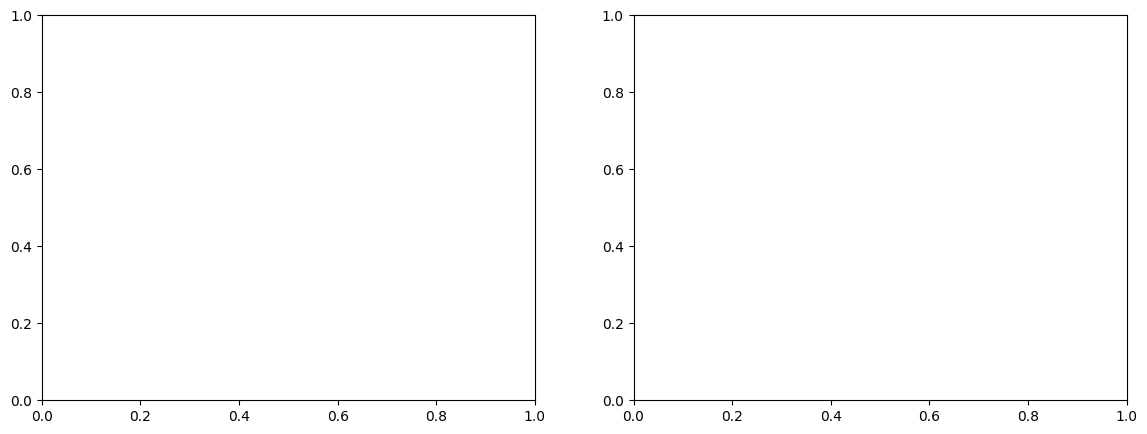

In [ ]:
# Plot 1: Comparison of metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison bar plot
metrics_to_plot = ['MAE', 'MSE', 'RMSE']
comparison_df[metrics_to_plot].T.plot(kind='bar', ax=axes[0], rot=0, width=0.8)
axes[0].set_title('Model Comparison: MAE, MSE, RMSE (Lower is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Error Value')
axes[0].legend(title='Model', loc='upper left')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(metrics_to_plot)

# R² comparison
r2_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost (Basic)', 'XGBoost (Optimized)'],
    'R² Score': [lr_metrics['R²'], xgb_basic_metrics['R²'], xgb_optimized_metrics['R²']]
})
r2_comparison.plot(x='Model', y='R² Score', kind='bar', ax=axes[1], 
                   color=['skyblue', 'lightcoral', 'lightgreen'], rot=45, width=0.7)
axes[1].set_title('R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R² Score')
axes[1].legend().remove()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [ ]:
# Plot 2: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sample for visualization (too many points)
sample_size_viz = min(5000, len(y_test))
sample_idx = np.random.choice(len(y_test), sample_size_viz, replace=False)

# Optimized XGBoost predictions
axes[0].scatter(y_test.iloc[sample_idx], xgb_optimized_predictions[sample_idx], alpha=0.5, s=1)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Ratings')
axes[0].set_ylabel('Predicted Ratings')
axes[0].set_title('XGBoost (Optimized): Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

# Basic XGBoost predictions
axes[1].scatter(y_test.iloc[sample_idx], xgb_basic_predictions[sample_idx], alpha=0.5, s=1)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Ratings')
axes[1].set_ylabel('Predicted Ratings')
axes[1].set_title('XGBoost (Basic): Actual vs Predicted')
axes[1].grid(True, alpha=0.3)

# Linear Regression predictions
axes[2].scatter(y_test.iloc[sample_idx], lr_predictions[sample_idx], alpha=0.5, s=1)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Ratings')
axes[2].set_ylabel('Predicted Ratings')
axes[2].set_title('Linear Regression: Actual vs Predicted')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Plot 3: Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sample_idx = np.random.choice(len(y_test), min(5000, len(y_test)), replace=False)

# Optimized XGBoost residuals
xgb_opt_residuals = y_test.iloc[sample_idx] - xgb_optimized_predictions[sample_idx]
axes[0].scatter(xgb_optimized_predictions[sample_idx], xgb_opt_residuals, alpha=0.5, s=1)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Ratings')
axes[0].set_ylabel('Residuals')
axes[0].set_title('XGBoost (Optimized): Residual Plot')
axes[0].grid(True, alpha=0.3)

# Basic XGBoost residuals
xgb_basic_residuals = y_test.iloc[sample_idx] - xgb_basic_predictions[sample_idx]
axes[1].scatter(xgb_basic_predictions[sample_idx], xgb_basic_residuals, alpha=0.5, s=1)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Ratings')
axes[1].set_ylabel('Residuals')
axes[1].set_title('XGBoost (Basic): Residual Plot')
axes[1].grid(True, alpha=0.3)

# Linear Regression residuals
lr_residuals = y_test.iloc[sample_idx] - lr_predictions[sample_idx]
axes[2].scatter(lr_predictions[sample_idx], lr_residuals, alpha=0.5, s=1)
axes[2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Predicted Ratings')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Linear Regression: Residual Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Feature Importance (XGBoost)


In [ ]:
# Display feature importance from Optimized XGBoost
feature_importance_opt = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_basic = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance - XGBoost (Optimized):")
print(feature_importance_opt)

print("\nFeature Importance - XGBoost (Basic):")
print(feature_importance_basic)

# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Optimized model
axes[0].barh(feature_importance_opt['Feature'], feature_importance_opt['Importance'], color='lightgreen')
axes[0].set_xlabel('Importance')
axes[0].set_title('Feature Importance - XGBoost (Optimized)', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Basic model
axes[1].barh(feature_importance_basic['Feature'], feature_importance_basic['Importance'], color='lightcoral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Feature Importance - XGBoost (Basic)', fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## Summary

This project successfully:
- ✅ Loaded and explored the movie ratings dataset
- ✅ Engineered features from user and movie statistics
- ✅ Trained two machine learning models (Linear Regression and Random Forest)
- ✅ Evaluated models using:
  - **MAE** (Mean Absolute Error)
  - **MSE** (Mean Squared Error)
  - **RMSE** (Root Mean Squared Error)
  - **R²** (R-squared/coefficient of determination)
- ✅ Created visualizations to understand model performance

The Random Forest model typically performs better than Linear Regression for this type of problem, capturing non-linear relationships in the data.
